In [44]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from math import sin

In [45]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [46]:
##### NEW CLASS TO HAVE MULTIPLE SLOTS
class FirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values) 
        winners = np.flip(adv_ranking[-self.n_slots:]) # important to flip the order from higher to lower
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

Let's configure the parameters to have the same values of the other parts of the project

In [47]:
import numpy as np

# Configuration parameters
ITERATIONS = 1000
AUCTIONS = 100
N_USERS = 1000
N_ADVERTISERS = 10    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = 100    # needed for the UCB algorithm
PRICES = np.linspace(0, 1, NUMBER_OF_ARMS)    # actual arms of the ucb algorithm
BUDGET = 400
NUMBER_OF_SLOTS = 3

lambda_fun_param = lambda s: 1/(s+(0.3))       # probability of the ad being seen given the position s ->  0.5 for first position, 0.33 for second, 0.25 for third, etc...
LAMBDAS = np.array([lambda_fun_param(i) for i in range(1, NUMBER_OF_SLOTS+1)])    # array of lambda values (for each slot)

Pattern definition

sorted from largest to smallest;  True


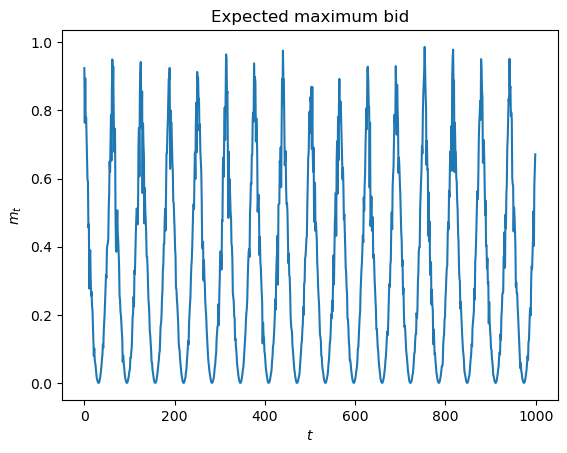

In [48]:
### Adversarial Bidders
#### interest !!
my_valuation = 1 # valuation will be scaled by the won slot prominence
rho = BUDGET/N_USERS

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(50*t/N_USERS))
other_bids = np.array([np.random.uniform(0, pattern(t), size = N_ADVERTISERS) for t in range(N_USERS)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)
other_bids_sorted = np.flip(np.sort(other_bids, axis=0), axis=0)
print("sorted from largest to smallest; ", np.all(other_bids_sorted[0, :] == m_t))

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()


#### Adversarial baseline:
$$ maximize~~~ \sum_b \gamma(b)(v - b)\bar{\mathbb{P}}_m(b \ge m) ~~~ s.t. \sum_b b \gamma(b) \bar{\mathbb{P}}_m(b \ge m) \le \rho,$$
#### where $\gamma(b)$ is the probability of bidding $b$ and $\bar{\mathbb{P}}_m(b \ge m)$ is the empirical win probability over all rounds. This is a Linear Program! (LP)

#### With multiple slots, the idea is to extend the expected reward $(v - b)\bar{\mathbb{P}}_m(b \ge m)$ from considering just the probability of obtaining the first slot, to the average of the probabilities of winning each slot, with the valuation $v$ weighted by the slot prominence $\lambda_s$:
$$ maximize~~~ \sum_b \gamma(b) \sum_s (\lambda_s v - b) \bar{\mathbb{P}}_m(m_s \le b \le m_{s+1}) ~~~ s.t. \sum_b b \gamma(b) \sum_s \bar{\mathbb{P}}_m(m_s \le b \le m_{s+1}) \le \rho,$$

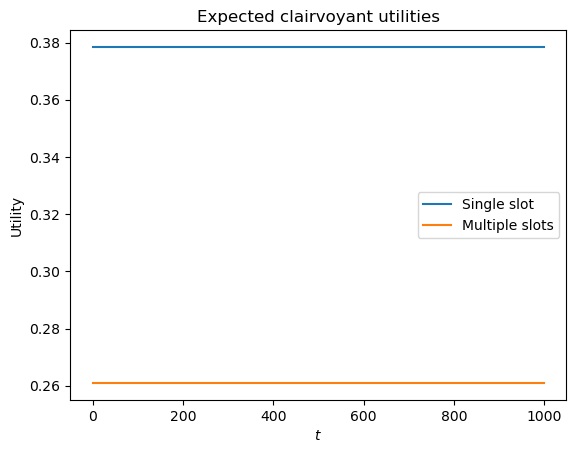

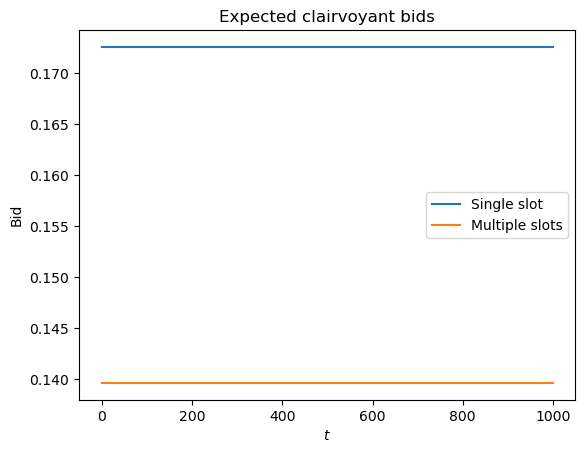

In [59]:
# single slot
win_probabilities = np.array([sum(b > m_t)/N_USERS for b in PRICES])
# multiple slots
def get_slot_won(bid, sorted_bids, n_slots):
    """Returns the slot won by the bid at a specific time-step"""
    for s in range(n_slots):
        if bid > sorted_bids[s]:
            return s
    return None
def get_bid_win_probabilities(bid, sorted_bids, lambdas):
    n_user = sorted_bids.shape[1]
    probabilities = np.zeros(len(lambdas))
    for u in range(n_user):
        slot = get_slot_won(bid, sorted_bids[:, u], len(lambdas))
        if slot is not None:
            probabilities[slot] += 1

    return probabilities/n_user

win_probabilities_multiple_slots = np.array([get_bid_win_probabilities(b, other_bids_sorted, LAMBDAS) for b in PRICES])

# single slot
c = -(my_valuation-PRICES)*win_probabilities
A_ub = [PRICES*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(PRICES))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(N_USERS)]
expected_clairvoyant_bids = [sum(PRICES*gamma*win_probabilities) for u in range(N_USERS)]

# multiple slots
c = np.zeros(len(PRICES))
for i, b in enumerate(PRICES):
    c[i] = -np.sum((my_valuation*LAMBDAS - b)*win_probabilities_multiple_slots[i, :])
    
A_ub = [PRICES*np.sum(win_probabilities_multiple_slots, axis=1)]
res = optimize.linprog(c, A_ub=A_ub, b_ub=[rho], A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities_multiple_slots = [-res.fun for u in range(N_USERS)]
expected_clairvoyant_bids_multiple_slots = [sum(PRICES*gamma*np.sum(win_probabilities_multiple_slots, axis=1)) for u in range(N_USERS)]

plt.plot(expected_clairvoyant_utilities, label='Single slot')
plt.plot(expected_clairvoyant_utilities_multiple_slots, label='Multiple slots')
plt.title('Expected clairvoyant utilities')
plt.xlabel('$t$')
plt.ylabel('Utility')
plt.legend()
plt.show()

plt.plot(expected_clairvoyant_bids, label='Single slot')
plt.plot(expected_clairvoyant_bids_multiple_slots, label='Multiple slots')
plt.title('Expected clairvoyant bids')
plt.xlabel('$t$')
plt.ylabel('Bid')
plt.legend()
plt.show()

### Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.
Full feedback = You know th bid of each competitor

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [50]:
class HedgeAgent:
    def __init__(self, narms, learning_rate): #ho tolto il numero di slot da questa classe per tenere solo narms
        self.narms = narms   #number of possible bids
        self.learning_rate = learning_rate #supposing it's the rate at which the algorithm progress
        self.weights = np.ones(narms) #weight == proportionnal to the probabilty
        self.x_t = np.ones(narms)/narms #probability of a bid to be played
        self.a_t = None # bid choice done during the round
        self.t = 0

    def pull_arm(self): #choose which arm to play
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.narms), p=self.x_t)
        return self.a_t

    def update(self, l_t): #update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [51]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta, lambdas):
        self.bids_set = bids_set #available choices
        self.K = len(bids_set) # number of possible bids
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation #what you earn, ctr*profit_per_click
        self.budget = budget
        self.eta = eta #learning rate for the pacing, i.e. how much we update the pacing multiplier
        self.T = T  #number of rounds
        self.rho = self.budget/self.T #bid limit
        self.lmbd = 1 #pacing multiplier, when we spend more than rho it increses otherwise we decrease it
        self.t = 0
        self.lambdas = lambdas

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, sorted_bids):
        # update hedge
        f_t_full = np.zeros(self.K)
        c_t_full = np.zeros(self.K)
        for i, b in enumerate(self.bids_set): # full (expert) feedback
            if (get_slot_won(b, sorted_bids, len(self.lambdas)) is not None):
                f_t_full[i] = self.valuation*self.lambdas[get_slot_won(b, sorted_bids, len(self.lambdas))] - b
                c_t_full[i] = b
                
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

## Trial

In [52]:
############## NEW - MARCO'S TEST ######################

### THIS IS THE NEW BLOCK OF THE FIRST TRIAL CONSIDERING MULTIPLE SLOTS
eta = 1/np.sqrt(N_USERS)  # Learning rate from theory

### BEFORE CREATING THE AUCTION WE NEED TO DEFINE CTRS (CLICK TO RATES)
# to define it we need LAMBDA which represents the probability that a slot is seen by the users and Qa which represents the probability that a user click the ad after seeing it
# we'll have a vector LAMBDA with as many values as the number of slots and a vector Qa that will be 2D: i'll have a different value for a different advertiser and a different slot (N_ADVERTISERS ROWS and NUMBER_OF_SLOTS columns)
# the click to rates wll be defined as: ctrs = LAMBDAS*Qa
# we already have a LAMBDAS vector from the parameter definition above but we need to create a vectore Qa
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


# Initializing the agent and auction
agent = FFMultiplicativePacingAgent(bids_set=PRICES,
                                    valuation=my_valuation,
                                    budget=BUDGET,
                                    T=N_USERS,
                                    eta=eta,
                                    lambdas=LAMBDAS)

auction = FirstPriceAuction(avg_ctrs, lambdas=LAMBDAS)  # Auction setup

# Arrays to store results
utilities = np.array([])  # Utility gained in each auction
my_bids = np.array([])  # Bids placed by the agent
my_payments = np.array([])  # Payments made by the agent
total_wins = 0  # Counter for total wins

# Running the auction process
np.random.seed(1)  # Seed for reproducibility

for u in range(N_USERS):
    my_win = 0
    rank = 0
    # Agent places a bid
    my_bid = agent.bid()

    # Gather all bids for this auction
    bids = np.append(my_bid, other_bids[:, u].ravel())
    m_t_new = np.max(bids)

    # Determine winners and payments
    winners, payments_per_click = auction.round(bids=bids)

    # Check if the agent won
    #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
    my_win = 0
    for i in range(len(winners)):
      if winners[i]==0:
        my_win = 1
        rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON
        break

    # Calculate the utility and payment for the agent
    f_t = (my_valuation*LAMBDAS[rank] - my_bid) if my_win else 0
    c_t = my_bid*my_win

    # Update the agent's learning based on the auction outcome
    agent.update(f_t, c_t, other_bids_sorted[:, u])

    # Store the results
    utilities = np.append(utilities, f_t)  # Append utility
    my_bids = np.append(my_bids, my_bid)  # Append bid
    my_payments = np.append(my_payments, c_t)  # Append payment
    total_wins += my_win  # Increment total wins

    cumulative_payments = np.cumsum(my_payments)

    # Nicely formatted output to track progress
    """print(f"\nIteration {u}:")  # New line for each iteration
    print(f"  My bid            : {my_bid:.2f}")
    print(f"  All bids          : {bids}")
    print(f"  All values        : {bids*avg_ctrs}")
    print(f"  Winners           : {winners}")
    print(f"  My win            : {my_win}")
    print(f"  m_t[{u}]          : {m_t_new:.2f}")
    print(f"  c_t               : {c_t:.2f}")
    print(f"  Total wins so far : {total_wins}")
    print(f"  Current payment   : {my_payments[u]}")
    print(f"  Total paid so far : {cumulative_payments[u]}")"""

# Display total number of wins at the end
print(f"Total number of wins: {total_wins}")


Total number of wins: 402


graphical representation

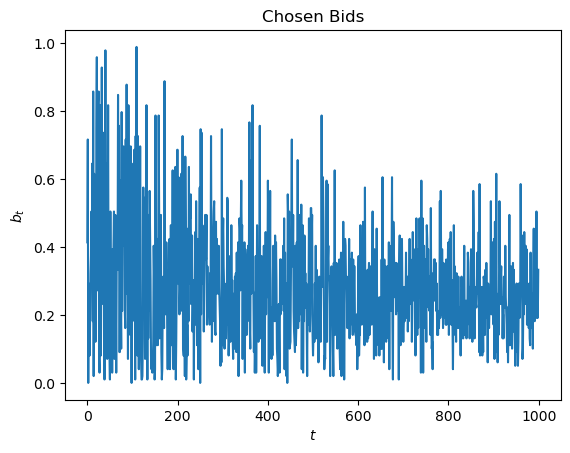

In [53]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

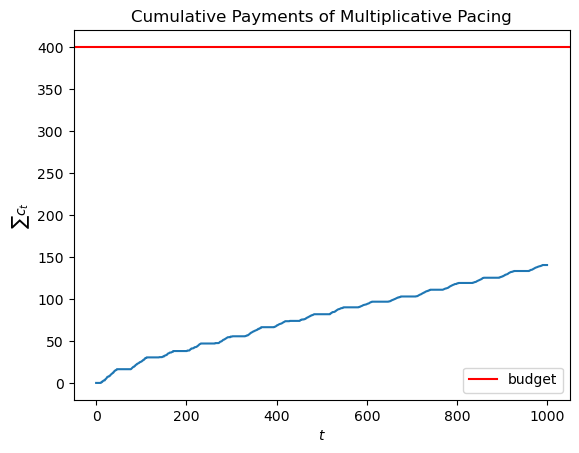

In [54]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(BUDGET, color='red', label='budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

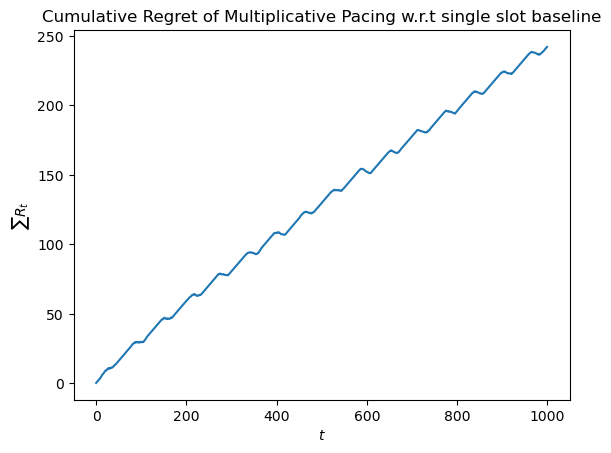

In [55]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing w.r.t single slot baseline')
plt.show()


#### Let's see the asymptotic behavior fitting a simple curve

Fitted exponent: 0.7318127721358427


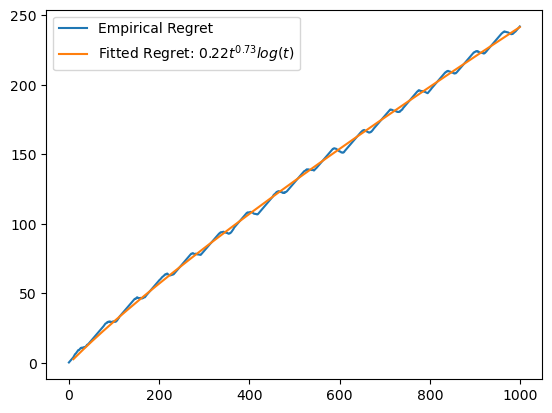

In [56]:
from scipy.optimize import curve_fit
fit_window = np.arange(10, N_USERS)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, cumulative_regret[fit_window])
ymodel = model(fit_window, *popt)
print('Fitted exponent:', popt[1])

fig, ax = plt.subplots()
ax.plot(np.arange(N_USERS), cumulative_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
ax.legend()

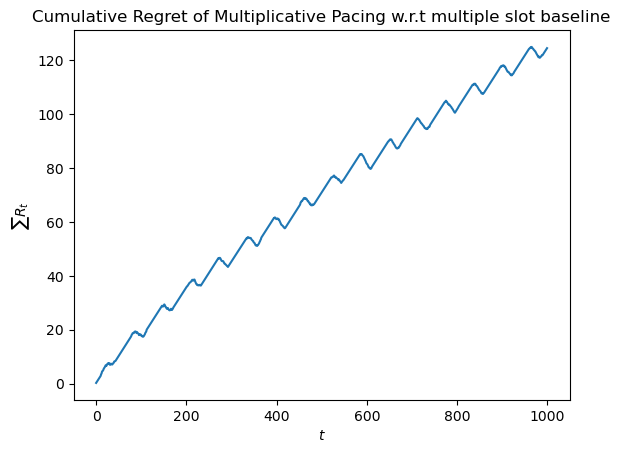

In [57]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities_multiple_slots-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing w.r.t multiple slot baseline')
plt.show()

Fitted exponent: 0.6453452557471594


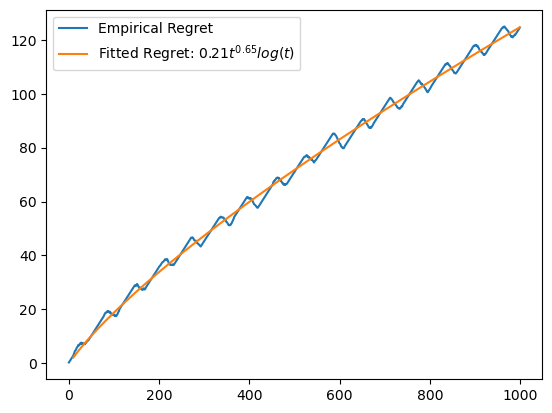

In [58]:
from scipy.optimize import curve_fit
fit_window = np.arange(10, N_USERS)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, cumulative_regret[fit_window])
ymodel = model(fit_window, *popt)
print('Fitted exponent:', popt[1])

fig, ax = plt.subplots()
ax.plot(np.arange(N_USERS), cumulative_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
ax.legend()

## now doing multiple rounds to have a better idea
### (only with multiple slot baseline) -> problem with multiple slot baseline solved

In [40]:
### SAME OF BEFORE, THIS IS THE NEW BLOCK FOR MULTIPLE SLOTS
all_regrets = []
all_payments = []

eta = 1/np.sqrt(N_USERS)  # Learning rate from theory
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


for i in range(ITERATIONS):
    agent = FFMultiplicativePacingAgent(bids_set = PRICES,
                                        valuation=my_valuation,
                                        budget=BUDGET,
                                        T=N_USERS,
                                        eta=eta,
                                        lambdas=LAMBDAS)

    auction = FirstPriceAuction(avg_ctrs, lambdas=LAMBDAS)  # Auction setup
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(N_USERS):
        my_win = 0
        rank = 0
        # Agent places a bid
        my_bid = agent.bid()

        # Gather all bids for this auction
        bids = np.append(my_bid, other_bids[:, u].ravel())
        m_t_new = np.max(bids)

        # Determine winners and payments
        winners, payments_per_click = auction.get_winners(bids=bids)

        # Check if the agent won
        #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
        my_win = 0
        for i in range(len(winners)):
            if winners[i]==0:
                my_win = 1
                rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON
                break

        # Calculate the utility and payment for the agent
        f_t = (my_valuation*LAMBDAS[rank] - my_bid) if my_win else 0
        c_t = my_bid*my_win

        # Update the agent's learning based on the auction outcome
        agent.update(f_t, c_t, other_bids_sorted[:, u])

        # Store the results
        utilities = np.append(utilities, f_t)  # Append utility
        my_bids = np.append(my_bids, my_bid)  # Append bid
        my_payments = np.append(my_payments, c_t)  # Append payment
        total_wins += my_win  # Increment total wins

        cumulative_payments = np.cumsum(my_payments)


    all_regrets.append(np.cumsum(expected_clairvoyant_utilities_multiple_slots-utilities))
    all_payments.append(cumulative_payments)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

graphical representation

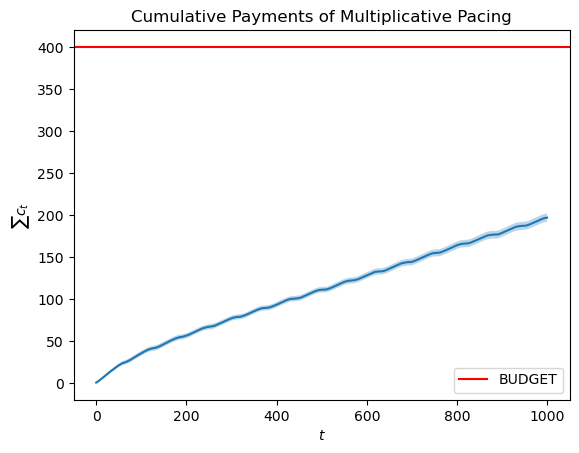

In [41]:
plt.plot(np.arange(N_USERS), avg_payments)
plt.fill_between(np.arange(N_USERS), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(BUDGET, color='red', label='BUDGET')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

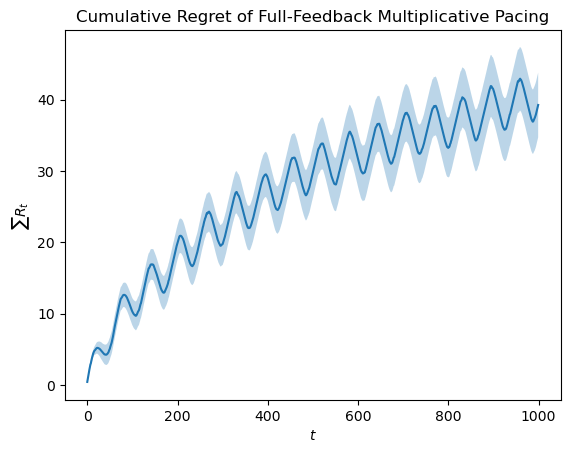

In [42]:
plt.plot(np.arange(N_USERS), avg_regret)
plt.fill_between(np.arange(N_USERS), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

### fit asymptotic behavior

Fitted exponent: 0.3428748679772379


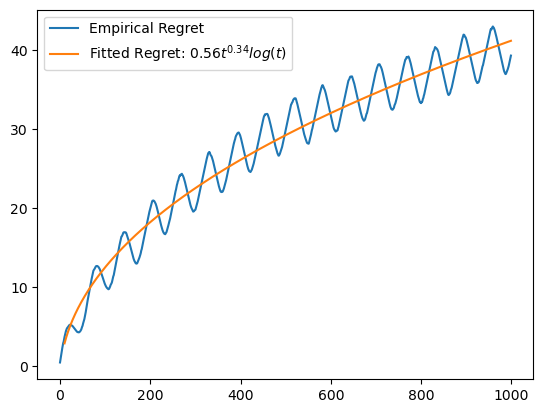

In [43]:
from scipy.optimize import curve_fit
fit_window = np.arange(10, N_USERS)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, avg_regret[fit_window])
ymodel = model(fit_window, *popt)
print('Fitted exponent:', popt[1])

fig, ax = plt.subplots()
ax.plot(np.arange(N_USERS), avg_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
ax.legend()